In [20]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt
from torchvision import models
from torch import nn

from tqdm import tqdm
from IPython.display import clear_output

from collections import defaultdict
import time

In [10]:
# !unzip classification-of-butterflies.zip

Streaming output truncated to the last 5000 lines.
  inflating: classification-of-butterflies/train_butterflies/train_split/class_9/4728.jpg  
  inflating: __MACOSX/classification-of-butterflies/train_butterflies/train_split/class_9/._4728.jpg  
  inflating: classification-of-butterflies/train_butterflies/train_split/class_9/2220.jpg  
  inflating: __MACOSX/classification-of-butterflies/train_butterflies/train_split/class_9/._2220.jpg  
  inflating: classification-of-butterflies/train_butterflies/train_split/class_9/3857.jpg  
  inflating: __MACOSX/classification-of-butterflies/train_butterflies/train_split/class_9/._3857.jpg  
  inflating: classification-of-butterflies/train_butterflies/train_split/class_9/4686.jpg  
  inflating: __MACOSX/classification-of-butterflies/train_butterflies/train_split/class_9/._4686.jpg  
  inflating: classification-of-butterflies/train_butterflies/train_split/class_9/3473.jpg  
  inflating: __MACOSX/classification-of-butterflies/train_butterflies/train_s

In [19]:
BATCH_SIZE = 128


# Путь к папке с данными
data_dir_train = 'classification-of-butterflies/train_butterflies/train_split'
data_dir_test = 'classification-of-butterflies/test_butterflies'

# Преобразования для изображений
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Изменение размера изображений
    transforms.RandomHorizontalFlip(p=0.2),
    transforms.RandomVerticalFlip(p=0.2),
    transforms.RandomRotation(10),
    transforms.ToTensor(),  # Преобразование в тензор
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Нормализация
])


train_dataset = datasets.ImageFolder(root=data_dir_train, transform=transform)
test_dataset = datasets.ImageFolder(root=data_dir_test, transform=transform)
class_mapping = {i: train_dataset.classes[i] for i in range(len(train_dataset.classes))}
print(f"{class_mapping=}")

train_size = int(0.8 * len(train_dataset))
valid_size = len(train_dataset) - train_size
train_dataset, valid_dataset = torch.utils.data.random_split(train_dataset, [train_size, valid_size])


train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


for images, labels in train_loader:
    print(images.shape)  # Размер батча: (batch_size, channels, height, width)
    print(labels)  # Метки классов
    break

class_mapping={0: 'class_0', 1: 'class_1', 2: 'class_10', 3: 'class_11', 4: 'class_12', 5: 'class_13', 6: 'class_14', 7: 'class_15', 8: 'class_16', 9: 'class_17', 10: 'class_18', 11: 'class_19', 12: 'class_2', 13: 'class_20', 14: 'class_21', 15: 'class_22', 16: 'class_23', 17: 'class_24', 18: 'class_25', 19: 'class_26', 20: 'class_27', 21: 'class_28', 22: 'class_29', 23: 'class_3', 24: 'class_30', 25: 'class_31', 26: 'class_32', 27: 'class_33', 28: 'class_34', 29: 'class_35', 30: 'class_36', 31: 'class_37', 32: 'class_38', 33: 'class_39', 34: 'class_4', 35: 'class_40', 36: 'class_41', 37: 'class_42', 38: 'class_43', 39: 'class_44', 40: 'class_45', 41: 'class_46', 42: 'class_47', 43: 'class_48', 44: 'class_49', 45: 'class_5', 46: 'class_6', 47: 'class_7', 48: 'class_8', 49: 'class_9'}
torch.Size([128, 3, 224, 224])
tensor([47, 39, 49, 17,  6, 23,  5, 47, 37, 35, 33, 41, 36, 29, 22, 20,  1, 28,
        37, 36,  8, 23, 44, 33, 35, 35, 40, 10, 38, 36, 30, 14, 29, 19, 12, 35,
        20, 29

tensor(31)


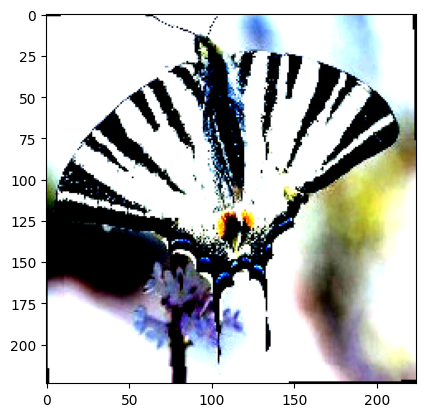

In [21]:
from matplotlib import pyplot as plt
for images, labels in train_loader:
    # print(images.shape)  # Размер батча: (batch_size, channels, height, width)
    print(labels[0])  # Метки классов
    plt.imshow(images[0,:,:,:].permute(1, 2, 0))

    break

In [22]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [24]:
from collections import  defaultdict

def train(
    model,
    criterion,
    optimizer,
    scheduler,
    train_batch_gen,
    val_batch_gen,
    num_epochs=10
):
    '''
    Функция для обучения модели и вывода лосса и метрики во время обучения.
    '''

    history = defaultdict(lambda: defaultdict(list))

    for epoch in range(num_epochs):
        train_loss = 0
        train_acc = 0
        val_loss = 0
        val_acc = 0

        start_time = time.time()

        # устанавливаем поведение dropout / batch_norm  в обучение
        model.train(True)
        model.to(device)

        # на каждой "эпохе" делаем полный проход по данным
        for X_batch, y_batch in tqdm(train_batch_gen):
            # обучаемся на текущем батче
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            logits = model(X_batch)

            loss = criterion(logits, y_batch.long().to(device))

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            train_loss += np.sum(loss.detach().cpu().numpy())
            y_pred = logits.max(1)[1].detach().cpu().numpy()
            train_acc += np.mean(y_batch.cpu().numpy() == y_pred)
        scheduler.step()

        # подсчитываем лоссы и сохраням в "историю"
        train_loss /= len(train_batch_gen)
        train_acc /= len(train_batch_gen)
        history['loss']['train'].append(train_loss)
        history['acc']['train'].append(train_acc)

        # устанавливаем поведение dropout / batch_norm в режим тестирования
        model.train(False)

        # полностью проходим по валидационному датасету
        for X_batch, y_batch in tqdm(val_batch_gen):
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            logits = model(X_batch)
            loss = criterion(logits, y_batch.long().to(device))
            val_loss += np.sum(loss.detach().cpu().numpy())
            y_pred = logits.max(1)[1].detach().cpu().numpy()
            val_acc += np.mean(y_batch.cpu().numpy() == y_pred)

        # подсчитываем лоссы и сохраням в "историю"
        val_loss /= len(val_batch_gen)
        val_acc /= len(val_batch_gen)
        history['loss']['val'].append(val_loss)
        history['acc']['val'].append(val_acc)

        clear_output()

        # печатаем результаты после каждой эпохи
        print("Epoch {} of {} took {:.3f}s".format(
            epoch + 1, num_epochs, time.time() - start_time))
        print("  training loss (in-iteration): \t{:.6f}".format(train_loss))
        print("  validation loss (in-iteration): \t{:.6f}".format(val_loss))
        print("  training accuracy: \t\t\t{:.2f} %".format(train_acc * 100))
        print("  validation accuracy: \t\t\t{:.2f} %".format(val_acc * 100))

        plot_learning_curves(history)

    return model, history

In [25]:
def plot_learning_curves(history):
    '''
    Функция для вывода графиков лосса и метрики во время обучения.
    '''
    fig = plt.figure(figsize=(20, 7))

    plt.subplot(1,2,1)
    plt.title('Лосс', fontsize=15)
    plt.plot(history['loss']['train'], label='train')
    plt.plot(history['loss']['val'], label='val')
    plt.ylabel('лосс', fontsize=15)
    plt.xlabel('эпоха', fontsize=15)
    plt.legend()

    plt.subplot(1,2,2)
    plt.title('Точность', fontsize=15)
    plt.plot(history['acc']['train'], label='train')
    plt.plot(history['acc']['val'], label='val')
    plt.ylabel('лосс', fontsize=15)
    plt.xlabel('эпоха', fontsize=15)
    plt.legend()
    plt.show()

In [31]:
import torchvision
resnet = torchvision.models.resnet18(weights=torchvision.models.ResNet18_Weights)

Epoch 5 of 5 took 23.326s
  training loss (in-iteration): 	0.070822
  validation loss (in-iteration): 	0.326736
  training accuracy: 			98.64 %
  validation accuracy: 			92.18 %


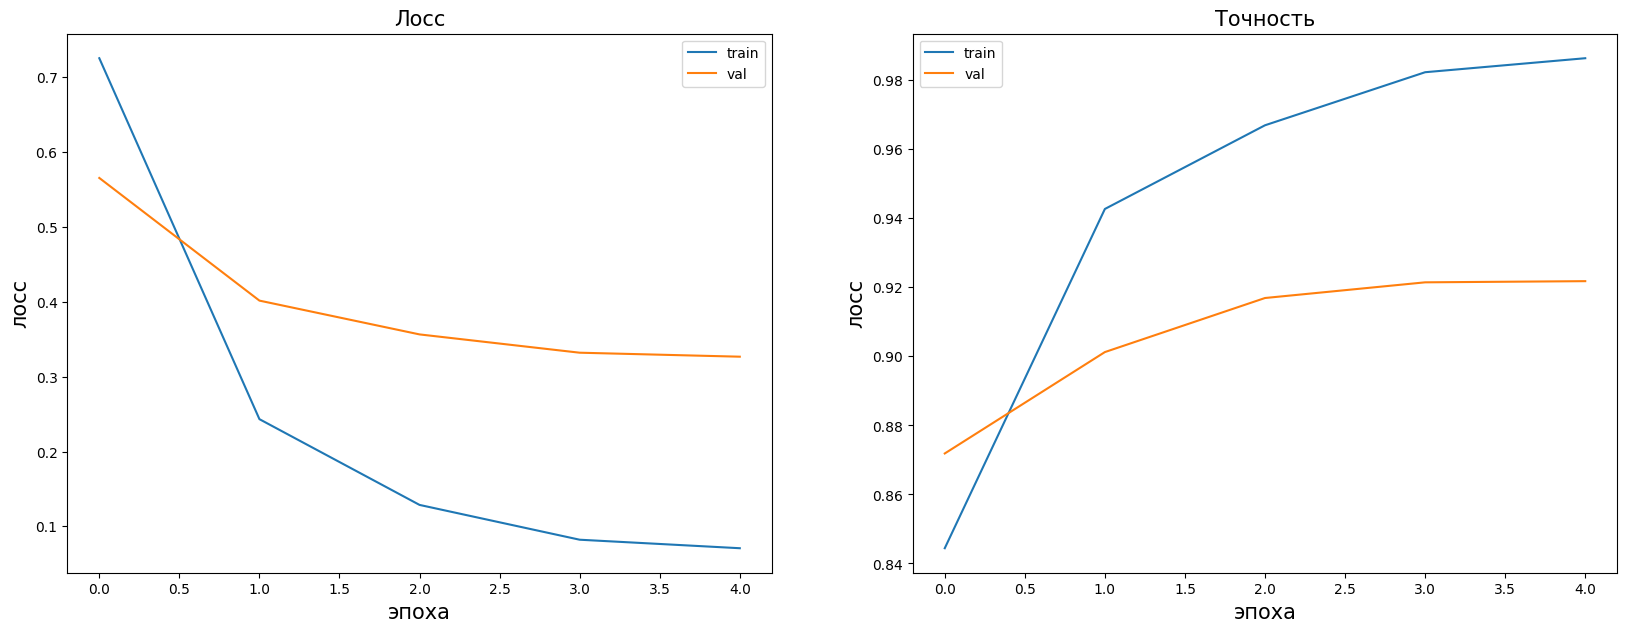

In [33]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet.parameters(), lr=1e-4)
scheduler = StepLR(optimizer, step_size=3, gamma=0.2)

clf_model, history = train(
    resnet, criterion, optimizer,
    scheduler, train_loader, valid_loader,
    num_epochs=5
)

In [34]:
import pandas as pd
test_dataset = datasets.ImageFolder(root=data_dir_test, transform=transform)


sample_name = [path.split('/')[-1].split('.')[0] for path, _ in test_dataset.samples]

data_pred = []
for data, _ in test_dataset:
    data_pred.append(data.clone().detach())

data_pred = torch.stack(data_pred, dim=0)
data_pred = data_pred.to(device)
pred = clf_model(data_pred)

str_nums = sorted([str(i) for i in range(50)])

to_real_index = {i : int(str_nums[i]) for i in range(50)}

res = [to_real_index[torch.argmax(item).item()] for item in pred]

cnt_output = len(res)

output = {
    "index": sample_name,
    "label": res,
}

output = pd.DataFrame(output)

In [35]:
output.to_csv('subm.csv', index=False)